importing the dependencies

In [86]:
#importing dependencies
import cv2
import os
import random
from matplotlib import pyplot as plt

In [88]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

GPU growth

In [91]:
#to avoid out of memory errors due to GPU overusage
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Create Directories

In [94]:
POS_PATH = os.path.join('data','positive')
ANC_PATH = os.path.join('data','anchor')
NEG_PATH = os.path.join('data','negative')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

Get the wild dataset into negative folder

In [ ]:
##uncompress the tar file 
!tar -xf lfw.tgz

In [ ]:
#moving the data from wild datset to negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw')):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        #print(NEW_PATH)
        #print(EX_PATH)
        os.replace(EX_PATH,NEG_PATH)

In [29]:
#calling the function called as open_webcam in another .py file for computing efficiency
from subprocess import call 

def open_webcam():
    call(['python','webcam_test.py'])

open_webcam()

Creating pipelines to access each file in the dataset

In [96]:
##Get image directories 
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)     #this will get the paths of each jpg file and stores in the variables
postive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)      
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)   ##TYPICALLY THIS 3 LINES CREATES PIPELINES FOR 3 DATASTES    

In [98]:
ANC_PATH+'/*.jpg'  # it gives the directory path to access the jpg files

'data/anchor/*.jpg'

In [100]:
dir = anchor.as_numpy_iterator()    #it will iterate to the file path 

In [102]:
dir.next()

b'data/anchor/e65d33f2-2499-11ef-8c5c-8e5257c51906.jpg'

preprocessing-->  Scale and Resize

In [105]:
def preprocess(file_path):
    #Read in image from the file path 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #resize the image to 100x100px
    img = tf.image.resize(img,(100,100))
    #Scale image to be between 0 & 1
    img = img/255.0
    
    return img

In [107]:
img=preprocess('data/anchor/7d035e08-249a-11ef-af29-8e5257c51906.jpg')

In [109]:
img.numpy().max()

1.0

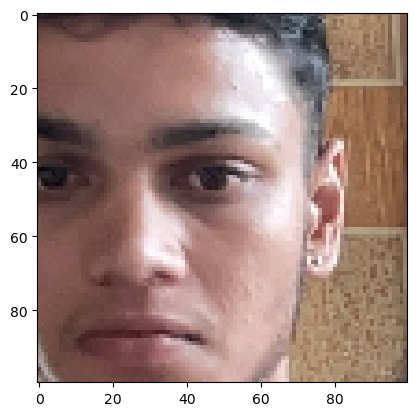

In [111]:
plt.imshow(img)

In [113]:
#dataset.map(preprocess)

In [115]:
positives = tf.data.Dataset.zip((anchor,postive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [117]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [119]:
sample = data.as_numpy_iterator()

In [121]:
sample.next()

(b'data/anchor/87b2a07a-249a-11ef-af29-8e5257c51906.jpg',
 b'data/positive/6c1ee8aa-249a-11ef-af29-8e5257c51906.jpg',
 1.0)

In [123]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img),label)

In [125]:
#build dataset pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [127]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [187]:
sample = data.as_numpy_iterator()

In [189]:
res=sample.next()

In [191]:
len(res)

3

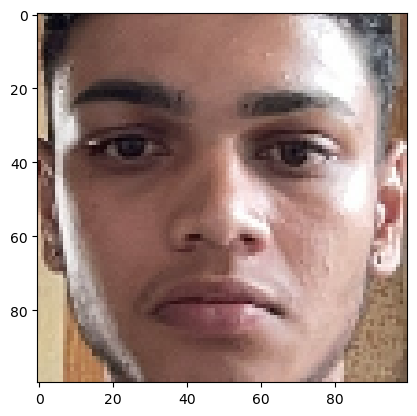

In [195]:
plt.imshow(res[0])

In [209]:
res[2]  # as we get the anchor and positive the label-------> 1.0
        #else_if we get anchor and negative the label-------> 0.0

1.0

In [211]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [233]:
#training partition
train_data = data.take(round(len(data)*.7))   #considering 70% of data for training
train_data = train_data.batch(16)
tarin_data = train_data.prefetch(8)

In [235]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [237]:
train_samples = train_data.as_numpy_iterator()

In [239]:
train_samples=train_samples.next()

In [241]:
len(train_samples[0])

16

In [251]:
#testing partition

test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))  #considering 30% of data for testing
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)